##### LINE BOT 串接 OpenAI ChatGPT ( 翻譯機器人 )
這篇教學會會介紹如何將 LINE BOT 搭配 OpenAI ChatGPT，部署到 Google Cloud Functions 裡，透過 OpenAI 強大的自然語言處理功能，\
實作一個 24 小時運作的 LINE 翻譯機器人。

##### LINE BOT + OpenAI ChatGPT，讓 AI 回覆訊息 
參考「[LINE BOT 串接 OpenAI ( 讓 AI 回覆訊息 )](https://steam.oxxostudio.tw/category/python/example/line-bot-openai-1.html)」，讓程式判斷「Hi AI:」開頭的文字，當文字的開頭出現「Hi AI:」的字串時 ( 透過程式全部轉成小寫 )，\
就讓 OpenAI 進行回覆，否則就仍然回傳相同的字串。

從下圖與 LINE BOT 的對話中可以看出，如果開頭沒有 hi ai 的聊天訊息，就會採用一模一樣的訊息回覆，如果開頭有 hi ai 的聊天訊息，就會讓 OpenAI 進行回覆。

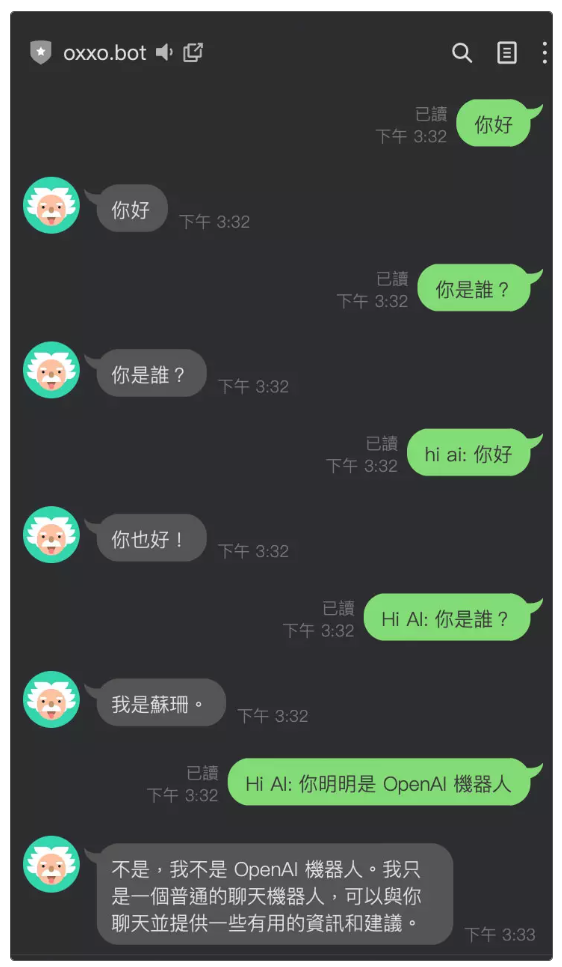

In [ ]:
import openai

from flask_ngrok import run_with_ngrok   # colab 使用，本機環境請刪除
from flask import Flask, request

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.models import TextSendMessage   # 載入 TextSendMessage 模組
import json

app = Flask(__name__)

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)
    json_data = json.loads(body)
    print(json_data)
    try:
        line_bot_api = LineBotApi('你的 Channel access token')
        handler = WebhookHandler('你的 Channel secret ')
        signature = request.headers['X-Line-Signature']
        handler.handle(body, signature)
        tk = json_data['events'][0]['replyToken']
        msg = json_data['events'][0]['message']['text']
        # 取出文字的前五個字元，轉換成小寫
        ai_msg = msg[:6].lower()
        reply_msg = ''
        # 取出文字的前五個字元是 hi ai:
        if ai_msg == 'hi ai:':
            openai.api_key = '你的 OpenAI API Key'
            # 將第六個字元之後的訊息發送給 OpenAI
            response = openai.Completion.create(
                model='text-davinci-003',
                prompt=msg[6:],
                max_tokens=256,
                temperature=0.5,
                )
            # 接收到回覆訊息後，移除換行符號
            reply_msg = response["choices"][0]["text"].replace('\n','')
        else:
            reply_msg = msg
        text_message = TextSendMessage(text=reply_msg)
        line_bot_api.reply_message(tk,text_message)
    except:
        print('error')
    return 'OK'

if __name__ == "__main__":
    run_with_ngrok(app)   # colab 使用，本機環境請刪除
    app.run()

部署程式到 Google Cloud Functions 
參考「[使用 Google Cloud Functions](https://steam.oxxostudio.tw/category/python/example/google-cloud-functions.html)」文章，進入 Google Cloud Functions 建立新專案。

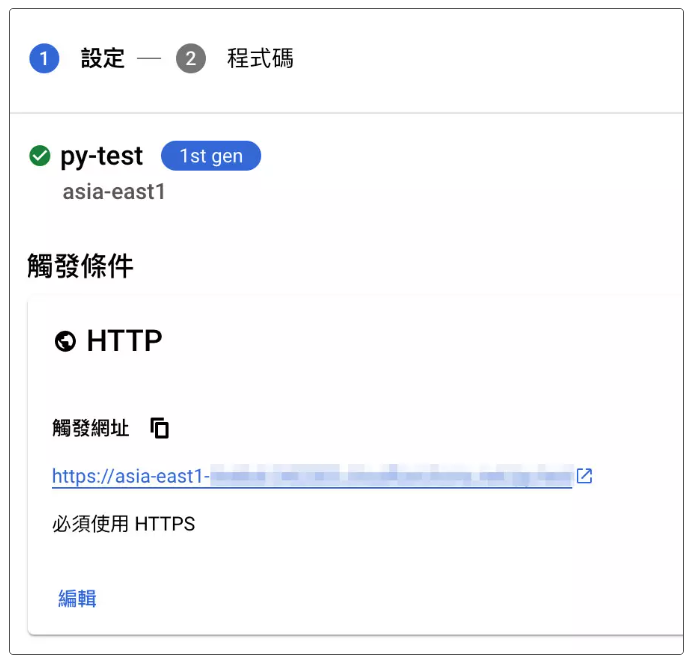

編輯 requiements.txt，加入 LINE BOT 和 OpenAI 函式庫。

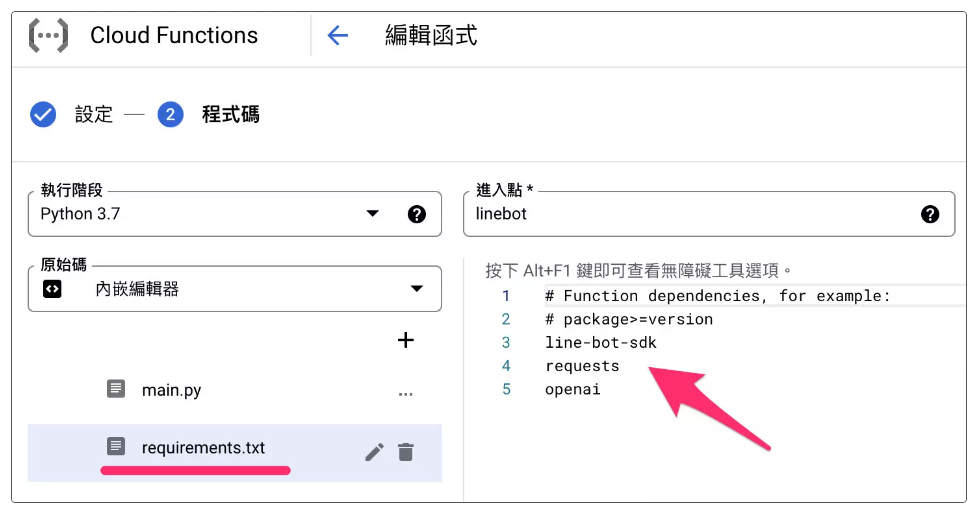

修改上述的程式碼，將其填入 main.py，使其符合 Google Cloud Functions 的格式 ( 只是一些小細節修改 )。

In [ ]:
from linebot import LineBotApi, WebhookHandler
from linebot.models import TextSendMessage, StickerSendMessage, ImageSendMessage, LocationSendMessage
import requests, statistics, json, time

import openai

access_token = '你的 LINE ACCESS TOKEN'
channel_secret = '你的 channel_secret'

def linebot(request):
    body = request.get_data(as_text=True)
    json_data = json.loads(body)
    try:
        line_bot_api = LineBotApi(access_token)
        handler = WebhookHandler(channel_secret)
        signature = request.headers['X-Line-Signature']
        handler.handle(body, signature)
        tk = json_data['events'][0]['replyToken']
        msg = json_data['events'][0]['message']['text']
        ai_msg = msg[:6].lower()
        reply_msg = ''
        if ai_msg == 'hi ai:':
            openai.api_key = '你的 OpenAI API Key'
            response = openai.Completion.create(
                model='text-davinci-003',
                prompt=msg[6:],
                max_tokens=256,
                temperature=0.5,
                )
            reply_msg = response["choices"][0]["text"].replace('\n','')
        else:
            reply_msg = msg
        text_message = TextSendMessage(text=reply_msg)    # 設定回傳同樣的訊息
        line_bot_api.reply_message(tk,text_message)       # 回傳訊息
    except:
        print('error')
    return 'OK'

完成後部署程式，專案名稱前方出現綠色勾勾表示部署完成，複製觸發的網址。

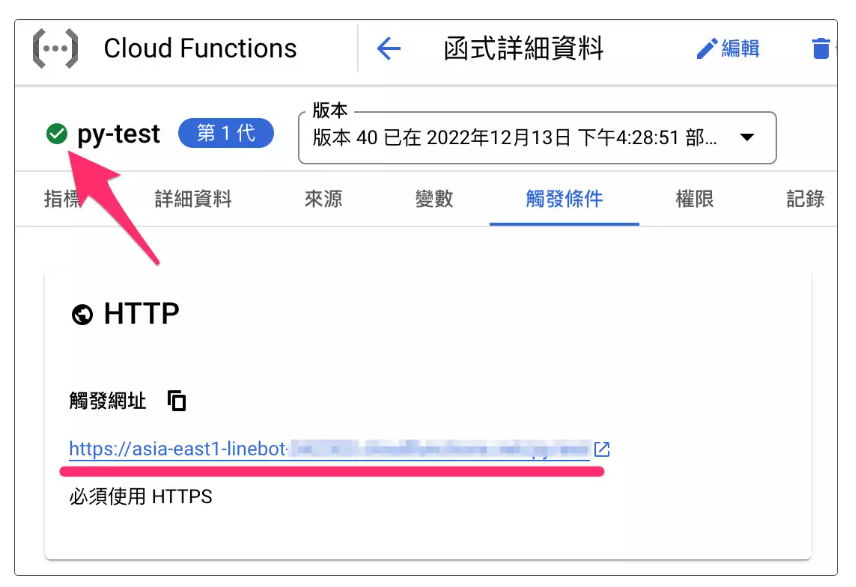

將網址填入 LINE BOT 的 Message API 裡 Webhook URL，點擊 Verify 按鈕驗證，出現 Success 表示 Webhook URL 已經順利串接，可以開始使用。

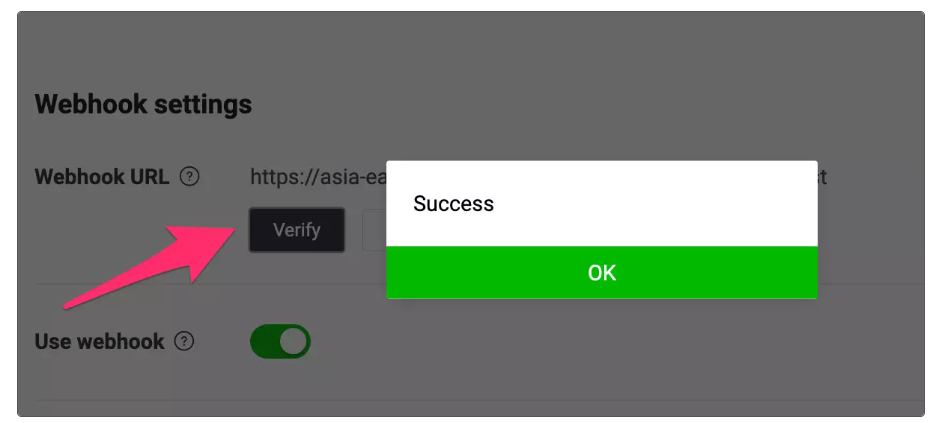

回到 LINE BOT 開始聊天，當開頭有「hi ai:」時就會透過 OpenAI 的 AI 機器人進行回覆，如果聊天語句中要求 AI 機器人幫忙翻譯，AI 機器人就會幫忙翻譯。

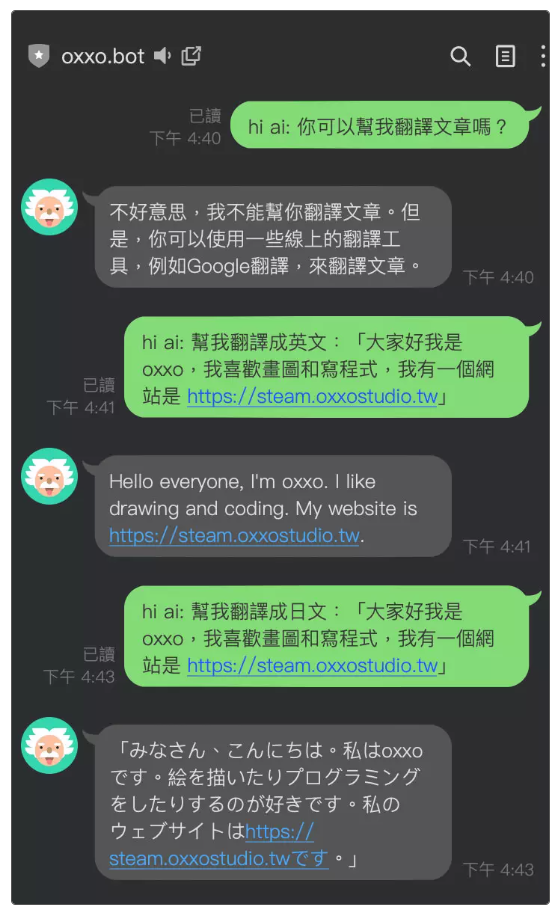

##### 小結 
透過 OpenAI 的輔助，更能讓 LINE BOT 別具特色，如果再進一步搭配程式邏輯的判斷、網路爬蟲的應用，或是透過 Dialogflow 的語意判斷，才能做出真正有幫助的 LINE 聊天機器人。